# Part 1: Modeling Challenge

1.) Use at least two classification techniques; compare and contrast the advantages and disadvantages of each.

LR - doesn't require normally distributed target class, nor factors that are normally distributed or bounded, however is susceptible to overfitting. 
RF - has built in methods for balancing error in unbalanced factors/classes, as well as gives feature importance estimates. Can also overfit like LR.

2.) Identify how you would control for overfitting in each classification technique.

LR - use l1/l2 regularization and C parameter
RF - use n_estimators to manage forest complexity, with CV / test accuracy as a feedback

3.) Evaluate the performance of each model.

Please see below

4.) In each model, identify the most important predictive variables and explain how you identified them.

Please see below


In [1]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.covariance import empirical_covariance
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
from numpy import array, random, take

## Data input and preprocessing

In [2]:
# read in external header file, data, and merge during import
with open("field_names.txt") as file:
    headerNames = [line.strip() for line in file]
data = pd.read_csv('breast-cancer.csv', names=headerNames)

# drop ID field, map diagnosis; malignant = 1, benign = 0, drop na's (none)
data.drop("ID", axis=1, inplace=True)
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})
data.dropna(inplace=True)

# split into X, y, test/train split, using 80/20 test/train split
X = array(data.drop(['diagnosis'], 1))
y = array(data['diagnosis'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# sanity check on array sizes
print("X_train.shape", X_train.shape),
print("X_test.shape", X_test.shape),
print("y_train.shape", y_train.shape),
print("y_test.shape", y_test.shape)

X_train.shape (455, 30)
X_test.shape (114, 30)
y_train.shape (455,)
y_test.shape (114,)


Mean: 2.00, smoothness_mean, malignant = 0
Median: 1.85, smoothness_mean, malignant = 0
Mean: 4.32, smoothness_mean, malignant = 1
Median: 3.68, smoothness_mean, malignant = 1
Mean: 0.02, compactness_mean, malignant = 0
Median: 0.02, compactness_mean, malignant = 0
Mean: 0.03, compactness_mean, malignant = 1
Median: 0.03, compactness_mean, malignant = 1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45e83f9d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f45e59bd3c8>]], dtype=object)

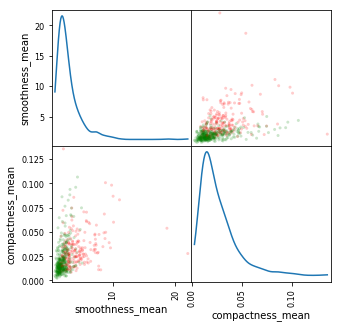

In [3]:
# show differences in mean/median between malignant/benign smoothness and compactness
# we have a ~2.2[unit] difference for mean smoothness, 0.01[unit] diff for mean compactness
factors = ['smoothness_mean', 'compactness_mean']
diagnoses = [0,1]

for factor in factors:
    for diagnosis in diagnoses:
        print('Mean: %.2f, %s, malignant = %s' %(data[factor].loc[data['diagnosis'] == diagnosis].mean(), factor, diagnosis))
        print('Median: %.2f, %s, malignant = %s' %(data[factor].loc[data['diagnosis'] == diagnosis].median(), factor, diagnosis))
        
mb_map = {0: "green", 1: "red"}
colors = data["diagnosis"].map(lambda x: mb_map.get(x))
pd.plotting.scatter_matrix(data.filter(items=['smoothness_mean', 'compactness_mean']), c=colors, alpha=0.2, figsize=(5, 5), diagonal='kde')

## Create bootstrapping function

In [4]:
# bootstrap function reads in numpy array and returns n bootstrapped samples
# note this is with replacement
def bootstrap(array, n):
    if n > array.shape[0]:
        n = array.shape[0]
    return array.take(random.randint(0, y.shape[0], n), axis=0)

In [5]:
# demonstration
y = array([[0, 2, 2], [3, 5, 4], [8, 7, 6], [1, 4, 6], [2, 5, 7]])
bootstrap(y, 4)

# example use on supplied data set (not executed for brevity)
# bootstrap(X_train, 4)

array([[3, 5, 4],
       [0, 2, 2],
       [8, 7, 6],
       [0, 2, 2]])

## Feature correlation

In [6]:
# output top 10 correlated factors to diagnosis, simple pearson's correlation
data.corr().iloc[:,0].tail(len(data.corr().iloc[:,0])-1).sort_values(ascending=False).head(10)

fractal_dimension_mean     0.793566
concave_points_sd_error    0.782914
perimeter_sd_error         0.776614
concavity_worst            0.776454
radius_worst               0.742636
concave_points_worst       0.733825
radius_mean                0.730029
texture_mean               0.708984
perimeter_mean             0.696360
symmetry_worst             0.659610
Name: diagnosis, dtype: float64

## Visually show predictive features
Here we can see the top 3 correlated features, dictated by the above Pearson's correlation coefficient pareto, to our target diagnosis class. Further investigation is needed to determine if this correlation is actually causation.

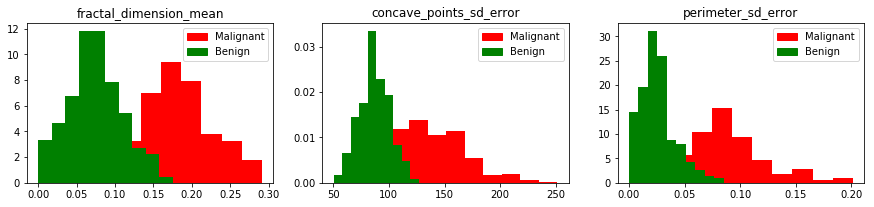

In [7]:
# put top 3 features from pearson's feature correllation, put into a list for plot
best_features = data.corr().iloc[:,0].tail(len(data.corr().iloc[:,0])-1).sort_values(ascending=False).head(3).index.tolist()

# plot top 3 predictive features for prediction of malignant/benign diagnosis
# need units added to charts here in the future
plt.figure(figsize=(15, 10))

for idx, feature in enumerate(best_features):
    plt.subplot(3,3,idx+1)
    plt.title(feature)
    plt.legend(handles = [patches.Patch(label = 'Malignant', color=('red')),
        patches.Patch(label = 'Benign', color=('green'))])
    m = data[data['diagnosis'] == 1][feature]
    b = data[data['diagnosis'] == 0][feature]
    plt.hist(m, color=('red'), stacked=True, normed = True)
    plt.hist(b, color=('green'), stacked=True, normed = True)

plt.show()

## Create and tune a Logistic Regression model 

In [8]:
# create a scoring helper function
def get_clf_score(pipeline):
    clf_pipe = pipeline
    clf_pipe_model = clf_pipe.fit(X_train, y_train)
    clf_test_score = clf_pipe_model.score(X=X_test, y=y_test)
    clf_cv_score = cross_val_score(clf_pipe, X_train, y=y_train, cv=10).mean()
    score = {'test': clf_test_score, 'cv': clf_cv_score}
    print('Accuracy against train set, CV: %.3f' %(score['cv']))
    print('Accuracy against test test: %.3f' %(score['test']))
    return None

In [9]:
# define untuned model pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=15)),
                    ('clf', LogisticRegression(random_state=1))])

In [10]:
# define tuned model pipeline using a grid search
lr_grid_params = {'clf__penalty': ['l1', 'l2'], 
                  'clf__C': [0.001,0.01,0.1,1,10,100]}
lr_grid_obj = GridSearchCV(estimator=pipe_lr,
                  param_grid=lr_grid_params,
                  scoring='accuracy',
                  cv=10)
lr_grid_model = lr_grid_obj.fit(X_train, y_train)
print('Best grid search accuracy of %.3f, C of %.2f, %s penalty\n' 
      %(lr_grid_model.best_score_, 
        lr_grid_model.best_params_['clf__C'], 
        lr_grid_model.best_params_['clf__penalty']))

# get stats of untuned and tuned model
print('Untuned Model:')
get_clf_score(pipe_lr)
print('')
print('Tuned Model:')
get_clf_score(lr_grid_model.best_estimator_)

Best grid search accuracy of 0.980, C of 0.10, l2 penalty

Untuned Model:
Accuracy against train set, CV: 0.978
Accuracy against test test: 0.982

Tuned Model:
Accuracy against train set, CV: 0.980
Accuracy against test test: 0.974


In [11]:
# descending list of top 10 feature imporance for logistic regression, using LR coefficients
fi_model = LogisticRegression(random_state=1)
fi_model.fit(X_train, y_train)

pd.Series(fi_model.coef_.transpose().reshape(30,),
          index=headerNames[2:]).sort_values(ascending=False).head(10)

symmetry_worst                1.219852
symmetry_sd_error             0.869772
perimeter_mean                0.495614
fractal_dimension_mean        0.417911
texture_worst                 0.322320
fractal_dimension_sd_error    0.314677
concave_points_mean           0.233365
perimeter_sd_error            0.222487
concave_points_sd_error       0.159417
symmetry_mean                 0.133269
dtype: float64

## Create and tune a Random Forest model

In [12]:
# define untuned model pipeline
pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=15)),
                    ('clf', RandomForestClassifier(n_estimators=100))])

# define tuned model pipeline using a grid search
rf_grid_params = {'clf__n_estimators': [1,5,10,20],
                 'clf__max_features': ['auto', 'sqrt', 'log2']}
rf_grid_obj = GridSearchCV(estimator=pipe_rf,
                  param_grid=rf_grid_params,
                  scoring='accuracy',
                  cv=10)
rf_grid_model = rf_grid_obj.fit(X_train, y_train)
print('Best grid search accuracy of %.3f, n_estimators of %.f, %s max features\n' 
      %(rf_grid_model.best_score_, 
        rf_grid_model.best_params_['clf__n_estimators'],
        rf_grid_model.best_params_['clf__max_features']))

# get stats of untuned and tuned model
print('Untuned Model:')
get_clf_score(pipe_rf)
print('')
print('Tuned Model:')
get_clf_score(rf_grid_model.best_estimator_)

Best grid search accuracy of 0.954, n_estimators of 20, sqrt max features

Untuned Model:
Accuracy against train set, CV: 0.941
Accuracy against test test: 0.947

Tuned Model:
Accuracy against train set, CV: 0.954
Accuracy against test test: 0.904


In [13]:
# descending list of top 10 feature imporance for Random Forest, using RF FI method
fi_model = RandomForestClassifier(n_estimators=100)
fi_model.fit(X_train, y_train)
pd.Series(fi_model.feature_importances_, 
          index=headerNames[2:]).sort_values(ascending=False).head(10)

concave_points_sd_error    0.151150
concavity_worst            0.142353
concave_points_worst       0.129670
fractal_dimension_mean     0.108413
perimeter_sd_error         0.076586
texture_mean               0.050138
symmetry_worst             0.045562
perimeter_mean             0.038861
radius_worst               0.034535
smoothness_sd_error        0.031145
dtype: float64

## Explanation of results
To Technical Audiences:

  Further dive into the subject matter and origins of the data with a SME would be in order. From this we would likely open doors for feature engineering and creating simpler, more targeted models rather than using the whole data set. Also, since this is a binary classification problem, more time to look into ROC metrics would likely be a good next step.

To Non-Technical Audiences:

  First, the input breast cancer data set was ingested and cleaned, removing any nulls and extraneous fields. Then, all features (smoothness, etc.) were input into two machine learnings models in the effort to predict the target class, diagnosis (malignant or benign). Tuning was performed on both of these models, and the result was 98% accuracy with one model, and 96% with the other. The most important predictive factors for the best performing model were symmetry_worst, symmetry_sd_error, and perimeter_mean.